In [1]:
# from vision_transformers.detection.rtdetr.rtdetr_model import load_model
from vision_transformers.detection.rtdetr import load_model
from torchvision import transforms

import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np

## Load Model

In [2]:
# Choose model between,
# rtdetr_resnet18, rtdetr_resnet34, rtdetr_resne50, rtdetr_resnet101
model = load_model('rtdetr_resnet101')

Load PResNet101 state_dict


In [3]:
print(model)

RTDETR(
  (backbone): PResNet(
    (conv1): Sequential(
      (conv1_1): ConvNormLayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(32, eps=1e-05)
        (act): ReLU(inplace=True)
      )
      (conv1_2): ConvNormLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(32, eps=1e-05)
        (act): ReLU(inplace=True)
      )
      (conv1_3): ConvNormLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(64, eps=1e-05)
        (act): ReLU(inplace=True)
      )
    )
    (res_layers): ModuleList(
      (0): Blocks(
        (blocks): ModuleList(
          (0): BottleNeck(
            (branch2a): ConvNormLayer(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm): FrozenBatchNorm2d(64, eps=1e-05)
    

In [4]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

76,556,268 total parameters.
76,556,268 training parameters.


## Load Image and Define Transforms

In [5]:
image = cv2.imread('../example_test_data/image_1.jpg')
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (640, 640))
print(orig_image.shape)

(426, 640, 3)


In [6]:
norm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

In [7]:
image = norm(image)
image.shape

torch.Size([3, 640, 640])

In [8]:
image = image.unsqueeze(0)

## Inference and Visualization

In [9]:
model.eval()
with torch.no_grad():
    out = model(image)

In [10]:
print(out.keys())

dict_keys(['pred_logits', 'pred_boxes'])


In [11]:
print(out['pred_logits'].shape)

torch.Size([1, 300, 80])


In [12]:
max_index = torch.argmax(out['pred_logits'][0])
print(max_index)

tensor(87)


In [13]:
print(out['pred_boxes'].shape)

torch.Size([1, 300, 4])


In [14]:
box = out['pred_boxes'][0][max_index].numpy()
print(box)

[0.52068627 0.32417557 0.01872814 0.02676342]


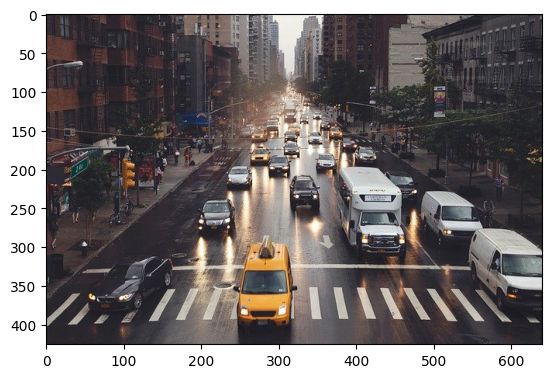

In [15]:
plt.imshow(orig_image[..., ::-1])

In [16]:
mscoco_category2name = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush'
}

mscoco_category2label = {k: i for i, k in enumerate(mscoco_category2name.keys())}
mscoco_label2category = {v: k for k, v in mscoco_category2label.items()}

In [17]:
COLORS = np.random.uniform(0, 255, size=(len(mscoco_category2name), 3))

In [18]:
for i in range(len(out['pred_boxes'][0])):
    logits = out['pred_logits'][0][i]
    soft_logits = torch.softmax(logits, dim=-1)
    max_index = torch.argmax(soft_logits)
    class_name = mscoco_category2name[mscoco_label2category[int(max_index.numpy())]]
    
    if soft_logits[max_index] > 0.50:
        box = out['pred_boxes'][0][i].numpy()
        cx, cy, w, h = box
        cx = cx * orig_image.shape[1]
        cy = cy * orig_image.shape[0]
        w = w * orig_image.shape[1]
        h = h * orig_image.shape[0]
        
        x1 = int(cx - (w//2))
        y1 = int(cy - (h//2))
        x2 = int(x1 + w)
        y2 = int(y1 + h)

        color = COLORS[max_index]
        
        cv2.rectangle(
            orig_image,
            (x1, y1),
            (x2, y2),
            thickness=2,
            color=color,
            lineType=cv2.LINE_AA
        )
        
        cv2.putText(
            orig_image,
            text=class_name,
            org=(x1, y1-10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.6,
            thickness=2,
            color=color,
            lineType=cv2.LINE_AA
        )

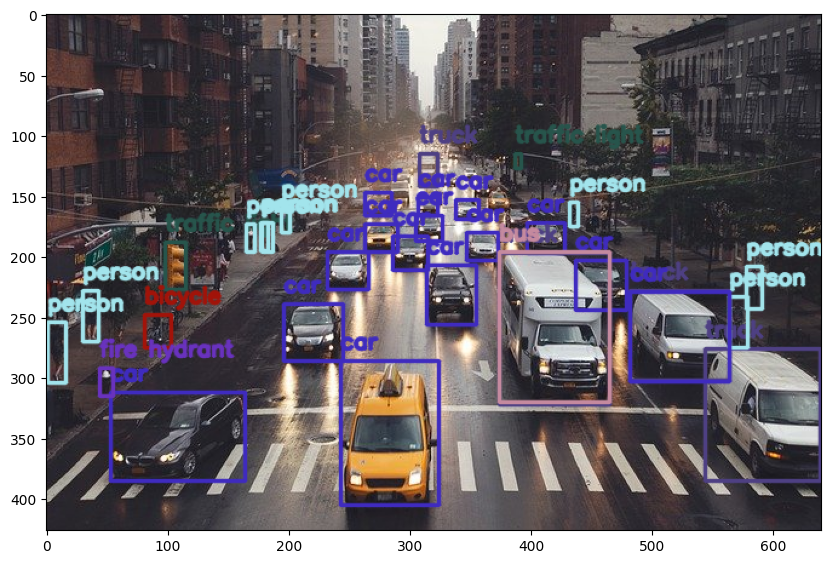

In [19]:
plt.figure(figsize=(10, 7))
plt.imshow(orig_image[..., ::-1])